ORACLE AKTIENANALYSE: ORCL
Zeitraum: 2020-01-01 bis 2024-12-31

✓ 1257 Handelstage geladen

--- KENNZAHLEN ---
Annualisierte Rendite:  32.28%
Annualisierte Volatilität: 32.81%
Sharpe Ratio: 0.86
Schiefe: 1.05
Kurtosis: 17.25

Max. Drawdown: -41.08% am 2022-09-30

--- ERSTELLE CHARTS ---


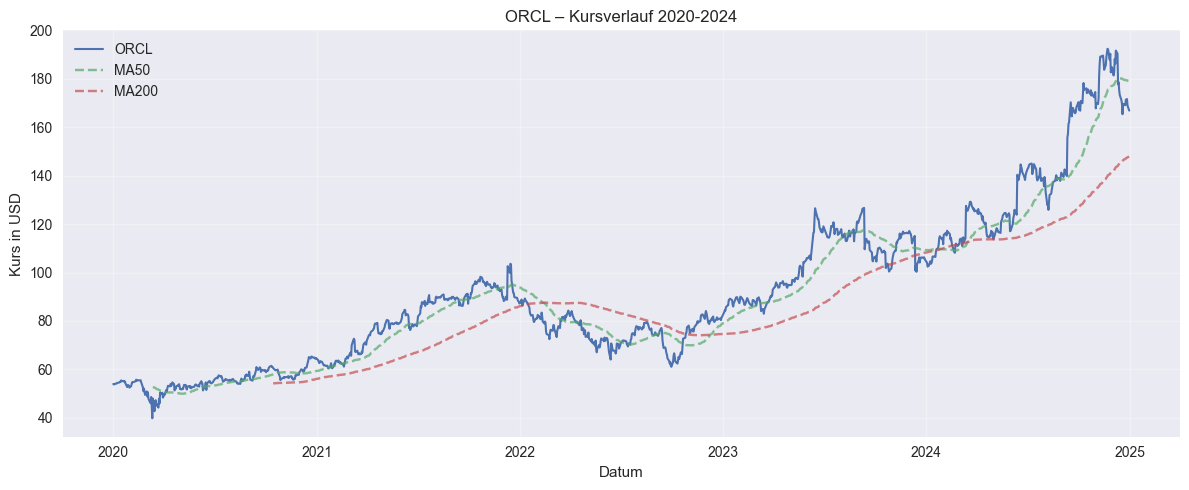

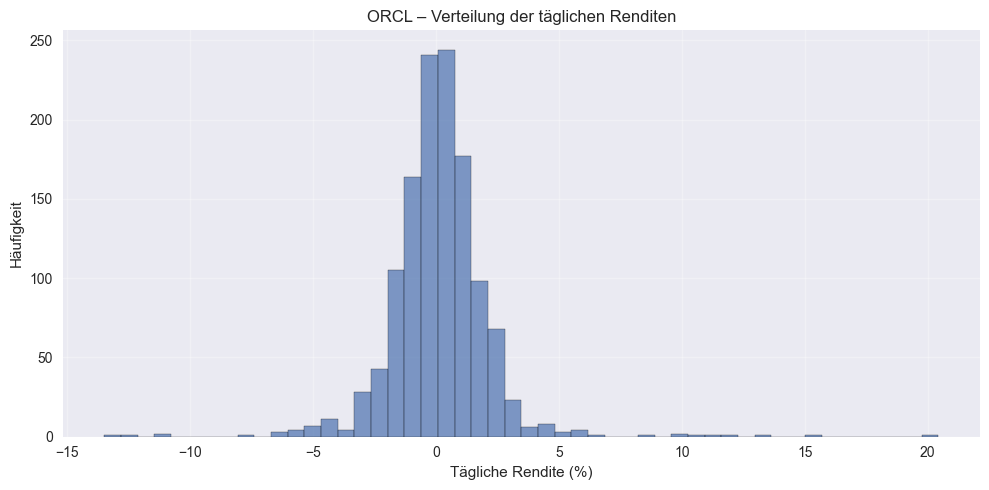

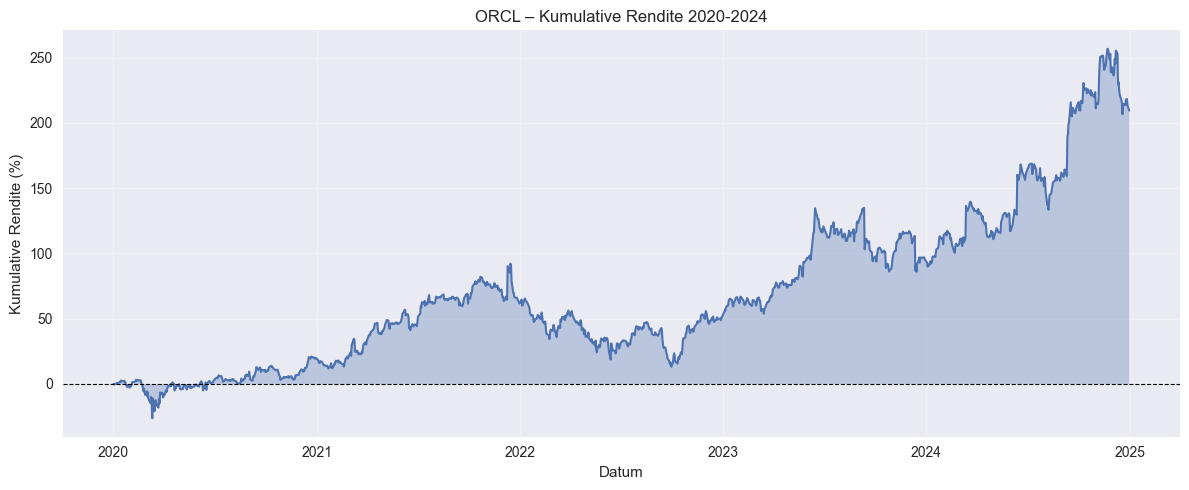

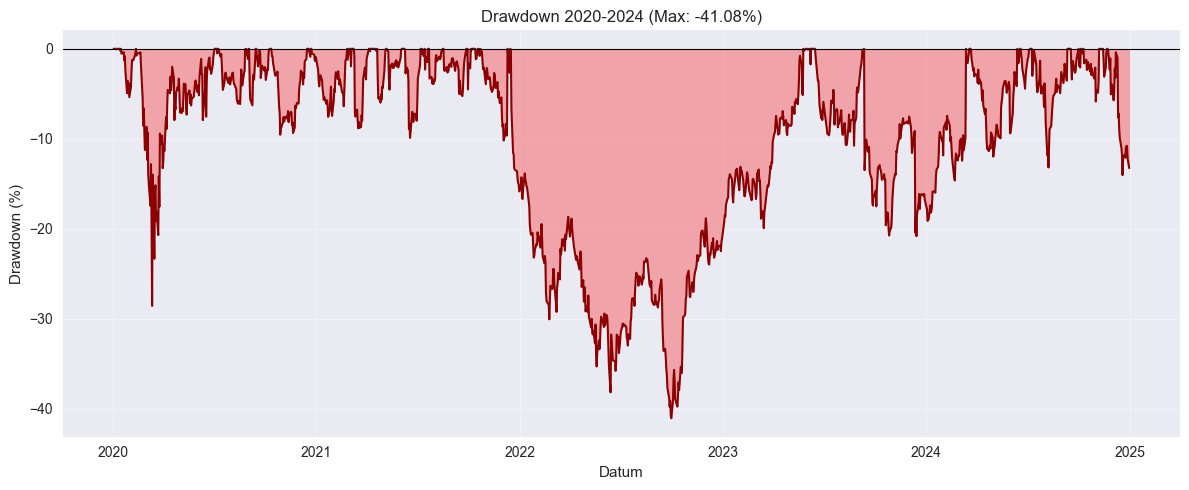

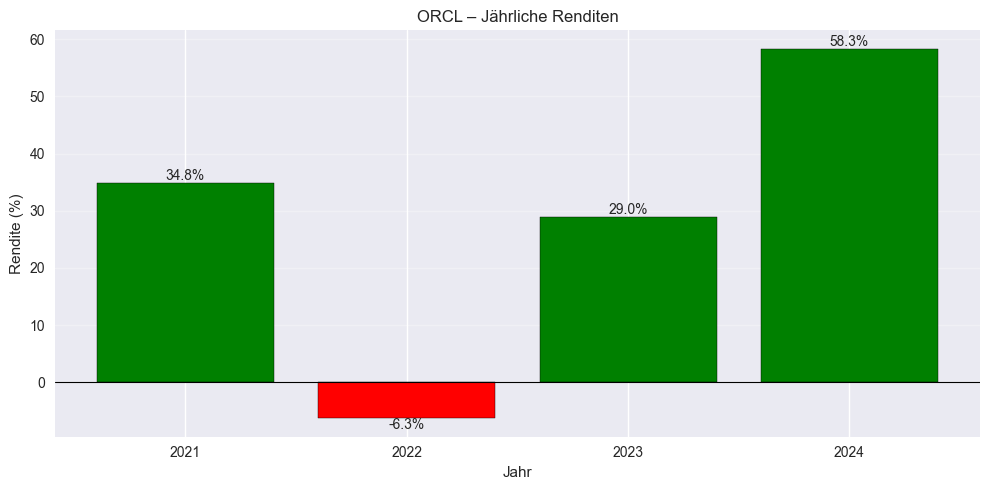

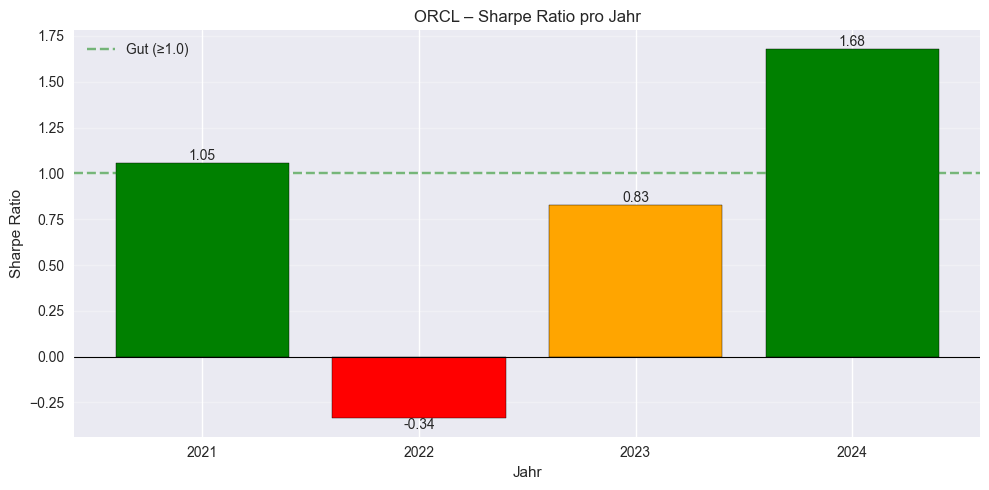

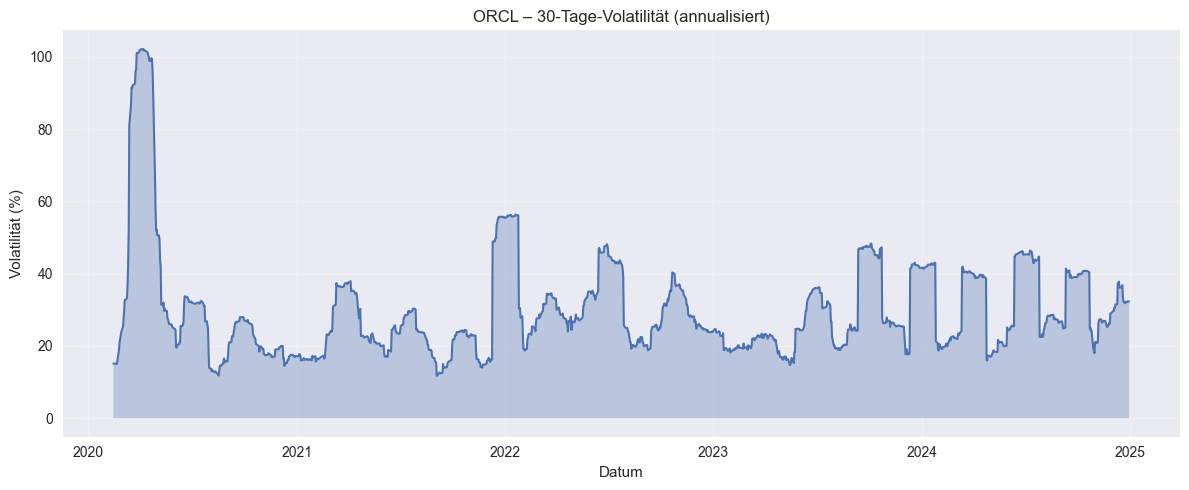

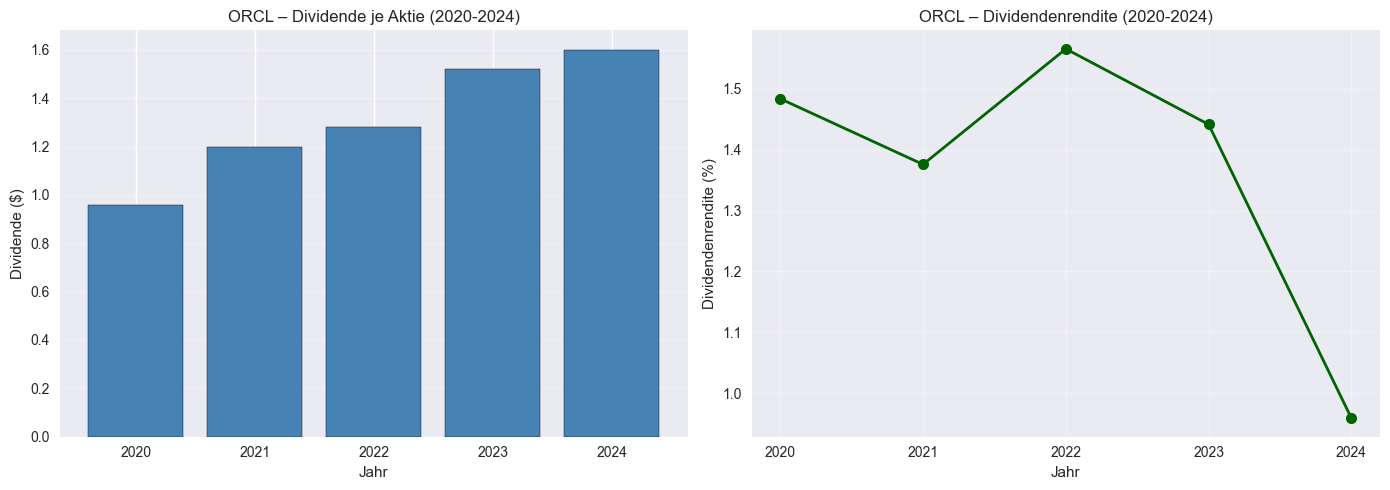


--- JAHRESÜBERSICHT ---
      Rendite (%)  Volatilität (%)  Dividende ($)  Div-Rendite (%)
Date                                                              
2020          NaN            40.59           0.96             1.48
2021        34.81            29.22           1.20             1.38
2022        -6.27            30.54           1.28             1.57
2023        28.98            30.21           1.52             1.44
2024        58.31            32.34           1.60             0.96

✓ ANALYSE ABGESCHLOSSEN
✓ 8 Charts gespeichert


In [7]:
# =============================================================================
# Oracle Aktienanalyse 2020-2024
# =============================================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

plt.style.use('seaborn-v0_8')

# =============================================================================
# KONFIGURATION
# =============================================================================

class Config:
    """Zentrale Konfiguration """

    # Aktien-Einstellungen
    TICKER = "ORCL"
    START = "2020-01-01"
    END = "2024-12-31"

    # Analyse-Parameter
    RISK_FREE_RATE = 0.04  # 4% für Sharpe Ratio
    TRADING_DAYS = 252     # Handelstage pro Jahr

    # Gleitende Durchschnitte
    MA_SHORT = 50          # Kurzfristiger Durchschnitt
    MA_LONG = 200          # Langfristiger Durchschnitt

    # Volatilität
    ROLLING_WINDOW = 30    # Tage für rollierende Volatilität

    # Chart-Einstellungen
    FIGSIZE_WIDE = (12, 5)
    FIGSIZE_MEDIUM = (10, 5)
    FIGSIZE_DOUBLE = (14, 5)
    DPI = 150              # Auflösung der gespeicherten Charts

# =============================================================================
# DATEN LADEN
# =============================================================================

def load_data(ticker, start, end):
    """Lädt Aktiendaten von Yahoo Finance"""
    try:
        raw = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)

        if raw.empty:
            print(f"❌ Keine Daten für {ticker} gefunden!")
            return None

        # MultiIndex behandeln
        if isinstance(raw.columns, pd.MultiIndex):
            raw.columns = raw.columns.get_level_values(0)

        data = raw[['Close']].dropna().rename(columns={'Close': 'Kurs'}).copy()
        print(f"✓ {len(data)} Handelstage geladen")
        return data

    except Exception as e:
        print(f"❌ Fehler: {e}")
        return None


# =============================================================================
# BERECHNUNGEN
# =============================================================================

def calculate_metrics(returns):

    # Durchschnittliche tägliche Rendite (arithmetisches Mittel)
    mean_daily = returns.mean()

    # Tägliche Volatilität (Standardabweichung = Maß für Schwankungen)
    vol_daily = returns.std()

    # ANNUALISIERUNG DER RENDITE
    # Formel: (1 + tägliche_rendite)^252 - 1
    # 252 = durchschnittliche Anzahl Handelstage pro Jahr
    # Beispiel: 0,1% täglich → (1.001)^252 - 1 = 28,5% jährlich
    annual_return = (1 + mean_daily) ** Config.TRADING_DAYS - 1

    # ANNUALISIERUNG DER VOLATILITÄT
    # Formel: tägliche_volatilität × √252
    # Wurzel weil Varianz linear mit Zeit skaliert, Standardabweichung mit √Zeit
    annual_vol = vol_daily * np.sqrt(Config.TRADING_DAYS)

    # SHARPE RATIO - Risikoadjustierte Rendite
    # Formel: (Rendite - Risikofreier_Zins) / Volatilität
    # Misst: Wie viel Überrendite pro Risikoeinheit?
    # Beispiel: Sharpe = 1,5 → 1,5% Überrendite pro 1% Risiko
    sharpe = (annual_return - Config.RISK_FREE_RATE) / annual_vol if annual_vol != 0 else 0

    return {
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'skew': returns.skew(),        # Schiefe: Asymmetrie der Verteilung
        'kurtosis': returns.kurtosis()  # Kurtosis: "Dicke" der Verteilungsenden
    }


def calculate_drawdown(returns):

    # SCHRITT 1: Kumulative Rendite berechnen
    # (1 + returns) gibt tägliche Wachstumsfaktoren: 1.02 = +2%, 0.98 = -2%
    # .cumprod() multipliziert alle: (1.02) × (0.98) × (1.01) × ...
    # Simuliert: Wie entwickelt sich 1€ Investment über Zeit?
    cum = (1 + returns).cumprod()

    # SCHRITT 2: Laufendes Maximum (höchster Wert bis zu jedem Zeitpunkt)
    # .cummax() speichert für jeden Tag den bisherigen Höchstwert
    # Beispiel: [1.0, 1.1, 1.05, 1.15] → [1.0, 1.1, 1.1, 1.15]
    running_max = cum.cummax()

    # SCHRITT 3: Drawdown berechnen
    # Formel: (Aktueller_Wert - Maximum) / Maximum
    # Beispiel: Kurs bei 80, Maximum war 100 → 80/100 - 1 = -0.2 = -20%
    # Zeigt: Wie weit sind wir vom Höchststand entfernt?
    drawdown = cum / running_max - 1

    # Finde größten Drawdown (negativster Wert)
    max_dd = drawdown.min()
    max_dd_date = drawdown.idxmin()

    return drawdown, max_dd, max_dd_date


# =============================================================================
# VISUALISIERUNGEN
# =============================================================================

def plot_price_with_ma(data, ticker):

    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Hauptkurslinie (Close-Preise)
    plt.plot(data.index, data['Kurs'], label=f'{ticker}', linewidth=1.5)

    # GLEITENDE DURCHSCHNITTE berechnen
    # .rolling(N) erstellt Fenster von N Tagen
    # .mean() berechnet Durchschnitt in diesem Fenster
    # Beispiel MA50: Durchschnitt der letzten 50 Tage
    data['MA50'] = data['Kurs'].rolling(Config.MA_SHORT).mean()
    data['MA200'] = data['Kurs'].rolling(Config.MA_LONG).mean()

    plt.plot(data.index, data['MA50'], label=f'MA{Config.MA_SHORT}', linestyle='--', alpha=0.7)
    plt.plot(data.index, data['MA200'], label=f'MA{Config.MA_LONG}', linestyle='--', alpha=0.7)

    plt.title(f'{ticker} – Kursverlauf 2020-2024')
    plt.xlabel('Datum')
    plt.ylabel('Kurs in USD')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('1_Kursverlauf.png', dpi=Config.DPI)
    plt.show()


def plot_returns_histogram(returns, ticker):

    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Renditen in Prozent für bessere Lesbarkeit
    # bins=50 → 50 Balken (Klassenbreite)
    plt.hist(returns * 100, bins=50, alpha=0.7, edgecolor='black')

    plt.title(f'{ticker} – Verteilung der täglichen Renditen')
    plt.xlabel('Tägliche Rendite (%)')
    plt.ylabel('Häufigkeit')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('2_Rendite_Histogramm.png', dpi=Config.DPI)
    plt.show()


def plot_cumulative_returns(data, ticker):
    """
    CHART 3: Kumulative Rendite

    Zeigt: Wie hat sich 1€ Investment entwickelt?

    Berechnung in main():
    data['Kum_Rendite'] = (1 + data['Rendite'].fillna(0)).cumprod() - 1

    Beispiel:
    - Start: 100€
    - Nach 5 Jahren: 150€
    - Kumulative Rendite: 50% (= 0.5 in der Grafik)

    Interpretation:
    - Steigend → Gewinn
    - Fallend → Verlust
    - Über 0 → Besser als Einstiegspunkt
    - Unter 0 → Schlechter als Einstiegspunkt
    """
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Kumulative Rendite in Prozent
    plt.plot(data.index, data['Kum_Rendite'] * 100, linewidth=1.5)

    # Fläche unter Kurve füllen (visuell ansprechender)
    plt.fill_between(data.index, 0, data['Kum_Rendite'] * 100, alpha=0.3)

    plt.title(f'{ticker} – Kumulative Rendite 2020-2024')
    plt.xlabel('Datum')
    plt.ylabel('Kumulative Rendite (%)')

    # Nulllinie (Einstiegspunkt)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('3_Kumulative_Rendite.png', dpi=Config.DPI)
    plt.show()


def plot_drawdown(drawdown, max_dd):
    """
    CHART 4: Drawdown-Verlauf

    Zeigt: Wie weit ist der Kurs vom bisherigen Höchststand entfernt?

    Berechnung: siehe calculate_drawdown()

    Interpretation:
    - Bei 0% → Neues Allzeithoch
    - Bei -20% → 20% unter dem bisherigen Maximum
    - Tiefster Punkt → Maximaler Drawdown (größter Verlust vom Hoch)

    Wichtig für:
    - Risikobewertung: "Wie schlimm kann es werden?"
    - Psychologie: "Kann ich -30% aushalten?"
    - Vergleich: Oracle vs. andere Aktien
    """
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Rote Fläche = Verlustzone
    plt.fill_between(drawdown.index, 0, drawdown * 100, color='red', alpha=0.3)

    # Drawdown-Linie
    plt.plot(drawdown.index, drawdown * 100, color='darkred', linewidth=1.5)

    plt.title(f'Drawdown 2020-2024 (Max: {max_dd:.2%})')
    plt.xlabel('Datum')
    plt.ylabel('Drawdown (%)')

    # Nulllinie (= am Höchststand)
    plt.axhline(0, color='black', linewidth=0.8)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('4_Drawdown.png', dpi=Config.DPI)
    plt.show()


def plot_annual_returns(annual_returns, ticker):
    """
    CHART 5: Jährliche Renditen (Year-over-Year)

    Zeigt: Performance pro Jahr

    Berechnung in main():
    1. year_end_close = Schlusskurs am 31.12. jedes Jahres
    2. annual_returns = .pct_change() = prozentuale Änderung zum Vorjahr

    Beispiel:
    - 2020 Ende: 100€
    - 2021 Ende: 120€
    - Jahresrendite 2021: +20%

    Interpretation:
    - Grüne Balken → Gewinn in diesem Jahr
    - Rote Balken → Verlust in diesem Jahr
    - Höhe → Stärke der Performance
    """
    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Farbcodierung: Grün für Gewinn, Rot für Verlust
    colors = ['green' if v >= 0 else 'red' for v in annual_returns.values]

    # Balkendiagramm
    bars = plt.bar(annual_returns.index.astype(str), annual_returns.values * 100,
                   color=colors, edgecolor='black')

    # Werte auf Balken schreiben (für genaue Zahlen)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center',
                va='bottom' if height >= 0 else 'top', fontsize=10)

    plt.title(f'{ticker} – Jährliche Renditen')
    plt.xlabel('Jahr')
    plt.ylabel('Rendite (%)')

    # Nulllinie
    plt.axhline(0, color='black', linewidth=0.8)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('5_Jahresrenditen.png', dpi=Config.DPI)
    plt.show()


def plot_sharpe_ratio(annual_returns, returns, ticker):
    """
    CHART 6: Sharpe Ratio pro Jahr

    Zeigt: Risikoadjustierte Performance (Rendite pro Risikoeinheit)

    Berechnung:
    1. Für jedes Jahr:
       - Filtere tägliche Renditen dieses Jahres
       - Berechne Jahresvolatilität: std × √252
       - Sharpe = (Jahresrendite - 4%) / Volatilität

    Interpretation:
    - < 0 (Rot) → Schlechter als risikofreie Anlage
    - 0-1 (Orange) → OK, aber nicht überragend
    - > 1 (Grün) → Gut, attraktives Risiko-Rendite-Verhältnis
    - > 2 → Sehr gut (selten!)

    Beispiel:
    - Sharpe = 1,5 → Für jedes 1% Risiko gab es 1,5% Überrendite
    """
    # Dictionary für Sharpe Ratios pro Jahr
    annual_sharpe = {}

    # Für jedes Jahr separat berechnen
    for year, annual_return in annual_returns.items():
        # SCHRITT 1: Filtere Renditen für dieses Jahr
        # returns.index.year extrahiert Jahr aus Datum
        # == year erstellt Boolean-Maske für dieses Jahr
        year_returns = returns[returns.index.year == year]

        # SCHRITT 2: Volatilität für dieses Jahr
        year_vol = year_returns.std() * np.sqrt(Config.TRADING_DAYS)

        # SCHRITT 3: Sharpe Ratio berechnen
        if year_vol != 0:
            annual_sharpe[year] = (annual_return - Config.RISK_FREE_RATE) / year_vol

    sharpe_series = pd.Series(annual_sharpe)

    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Farbcodierung nach Qualität
    colors = ['green' if v >= 1 else 'orange' if v >= 0 else 'red'
              for v in sharpe_series.values]

    bars = plt.bar(sharpe_series.index.astype(str), sharpe_series.values,
                   color=colors, edgecolor='black')

    # Werte auf Balken
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center',
                va='bottom' if height >= 0 else 'top', fontsize=10)

    plt.title(f'{ticker} – Sharpe Ratio pro Jahr')
    plt.xlabel('Jahr')
    plt.ylabel('Sharpe Ratio')

    # Referenzlinien
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axhline(1, color='green', linestyle='--', alpha=0.5, label='Gut (≥1.0)')

    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('6_Sharpe_Ratio.png', dpi=Config.DPI)
    plt.show()


def plot_volatility(vol_30d, ticker):
    """
    CHART 7: Rollierende 30-Tage-Volatilität (annualisiert)

    Zeigt: Wie sich das Risiko über Zeit verändert

    Berechnung in main():
    vol_30d = returns.rolling(30).std() × √252

    Erklärung:
    - .rolling(30) → Fenster von 30 Tagen
    - .std() → Standardabweichung in diesem Fenster
    - × √252 → Annualisierung (auf Jahresbasis)

    Das Fenster "rollt" über die Daten:
    - Tag 1-30: Volatilität für diese 30 Tage
    - Tag 2-31: Volatilität für diese 30 Tage
    - Tag 3-32: Volatilität für diese 30 Tage
    - usw.

    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Volatilität in Prozent
    plt.plot(vol_30d.index, vol_30d.values * 100, linewidth=1.5)

    # Fläche füllen
    plt.fill_between(vol_30d.index, 0, vol_30d.values * 100, alpha=0.3)

    plt.title(f'{ticker} – {Config.ROLLING_WINDOW}-Tage-Volatilität (annualisiert)')
    plt.xlabel('Datum')
    plt.ylabel('Volatilität (%)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('7_Volatilität.png', dpi=Config.DPI)
    plt.show()


"""

# =============================================================================
# HAUPTPROGRAMM
# =============================================================================

def main():
    """
    Hauptfunktion: Führt die komplette Aktienanalyse durch

    Ablauf:
    1. Daten laden
    2. Renditen berechnen
    3. Kennzahlen ermitteln
    4. Visualisierungen erstellen
    5. Zusammenfassung ausgeben
    """
    # Header ausgeben
    print("="*70)
    print(f"ORACLE AKTIENANALYSE: {Config.TICKER}")
    print(f"Zeitraum: {Config.START} bis {Config.END}")
    print("="*70 + "\n")

    # ==========================================================================
    # SCHRITT 1: DATEN LADEN
    # ==========================================================================
    data = load_data(Config.TICKER, Config.START, Config.END)
    if data is None:
        return  # Beende bei Fehler

    # ==========================================================================
    # SCHRITT 2: RENDITEN BERECHNEN
    # ==========================================================================
    # Tägliche Renditen = prozentuale Änderung von Tag zu Tag
    # .pct_change() berechnet: (Kurs_heute - Kurs_gestern) / Kurs_gestern
    # Beispiel: 100€ → 102€ ergibt 0.02 (2% Rendite)
    data['Rendite'] = data['Kurs'].pct_change()

    # Entferne erste Zeile (NaN, da kein Vortag)
    returns = data['Rendite'].dropna()

    # ==========================================================================
    # SCHRITT 3: KENNZAHLEN BERECHNEN
    # ==========================================================================
    print("\n--- KENNZAHLEN ---")
    metrics = calculate_metrics(returns)
    print(f"Annualisierte Rendite:  {metrics['annual_return']:.2%}")
    print(f"Annualisierte Volatilität: {metrics['annual_vol']:.2%}")
    print(f"Sharpe Ratio: {metrics['sharpe']:.2f}")
    print(f"Schiefe: {metrics['skew']:.2f}")
    print(f"Kurtosis: {metrics['kurtosis']:.2f}")

    # ==========================================================================
    # SCHRITT 4: DRAWDOWN ANALYSIEREN
    # ==========================================================================
    drawdown, max_dd, max_dd_date = calculate_drawdown(returns)
    print(f"\nMax. Drawdown: {max_dd:.2%} am {max_dd_date.date()}")

    # ==========================================================================
    # SCHRITT 5: KUMULATIVE RENDITE BERECHNEN
    # ==========================================================================
    # Zeigt: Wie hat sich 1€ Investment entwickelt?
    # Formel: (1 + r1) × (1 + r2) × ... - 1
    # Beispiel:
    #   Tag 1: +2% → 1.02
    #   Tag 2: +1% → 1.02 × 1.01 = 1.0302
    #   Kumulative Rendite: 3.02%
    data['Kum_Rendite'] = (1 + data['Rendite'].fillna(0)).cumprod() - 1

    # ==========================================================================
    # SCHRITT 6: VISUALISIERUNGEN ERSTELLEN
    # ==========================================================================
    print("\n--- ERSTELLE CHARTS ---")

    # Chart 1: Kursverlauf mit MA50 und MA200
    plot_price_with_ma(data, Config.TICKER)

    # Chart 2: Histogramm der täglichen Renditen
    plot_returns_histogram(returns, Config.TICKER)

    # Chart 3: Kumulative Rendite über Zeit
    plot_cumulative_returns(data, Config.TICKER)

    # Chart 4: Drawdown (Abstand vom Höchststand)
    plot_drawdown(drawdown, max_dd)

    # ==========================================================================
    # SCHRITT 7: JAHRESANALYSE
    # ==========================================================================
    # Jahresendkurse extrahieren
    # .resample('YE') gruppiert nach Jahresende
    # .last() nimmt den letzten Wert jedes Jahres (31.12.)
    year_end_close = data['Kurs'].resample('YE').last()

    # Jährliche Renditen berechnen
    # .pct_change() vergleicht Jahr zu Jahr
    # Beispiel: 2020: 100€, 2021: 120€ → Rendite 2021: 20%
    annual_returns = year_end_close.pct_change().dropna()
    annual_returns.index = annual_returns.index.year  # Index zu Jahren konvertieren

    # Chart 5: Jährliche Renditen (Balkendiagramm)
    plot_annual_returns(annual_returns, Config.TICKER)

    # Chart 6: Sharpe Ratio pro Jahr
    plot_sharpe_ratio(annual_returns, returns, Config.TICKER)

    # ==========================================================================
    # SCHRITT 8: VOLATILITÄT (ROLLIEREND)
    # ==========================================================================
    # Rollierende 30-Tage-Volatilität
    # .rolling(30) erstellt Fenster von 30 Tagen
    # .std() berechnet Standardabweichung in jedem Fenster
    # × √252 rechnet auf Jahresbasis hoch
    #
    # Zeigt: Wie verändert sich das Risiko über Zeit?
    vol_30d = returns.rolling(Config.ROLLING_WINDOW).std() * np.sqrt(Config.TRADING_DAYS)

    # Chart 7: Volatilität über Zeit
    plot_volatility(vol_30d, Config.TICKER)

    # ==========================================================================
    # SCHRITT 9: DIVIDENDEN ANALYSIEREN
    # ==========================================================================
    # Dividenden von Yahoo Finance laden
    stock = yf.Ticker(Config.TICKER)
    dividends = stock.dividends.loc[Config.START:Config.END]

    if not dividends.empty:
        # Jährliche Dividenden summieren
        # .resample("YE") gruppiert nach Jahresende
        # .sum() addiert alle Dividenden eines Jahres
        annual_dividends = dividends.resample("YE").sum().dropna()
        annual_dividends.index = annual_dividends.index.year

        # Nur Jahre 2020-2024 (Sicherheitsfilter)
        annual_dividends = annual_dividends[(annual_dividends.index >= 2020) &
                                           (annual_dividends.index <= 2024)]

        # Jahresendkurse für Dividendenrendite
        year_end_close_year = year_end_close.copy()
        year_end_close_year.index = year_end_close_year.index.year
        year_end_close_year = year_end_close_year[(year_end_close_year.index >= 2020) &
                                                   (year_end_close_year.index <= 2024)]

        # Dividendenrendite berechnen
        # Formel: Dividende / Aktienkurs
        # Beispiel: 2$ Dividende / 100$ Kurs = 2% Rendite
        dividend_yield = (annual_dividends / year_end_close_year).dropna()

        # Chart 8: Dividenden (2 Subplots)
        plot_dividends(annual_dividends, dividend_yield, Config.TICKER)

    # ==========================================================================
    # SCHRITT 10: JAHRESÜBERSICHT ERSTELLEN
    # ==========================================================================
    # Volatilität pro Jahr berechnen
    # .resample("YE") gruppiert nach Jahr
    # .std() berechnet Standardabweichung pro Jahr
    # × √252 annualisiert auf Jahresbasis
    annual_vol = returns.resample("YE").std() * np.sqrt(Config.TRADING_DAYS)
    annual_vol.index = annual_vol.index.year

    # Tabelle mit allen Jahresmetriken erstellen
    overview = pd.DataFrame({
        "Rendite (%)": (annual_returns * 100).round(2),          # Jahresrenditen
        "Volatilität (%)": (annual_vol * 100).round(2),          # Jahresvolatilität
        "Dividende ($)": annual_dividends.round(2) if not dividends.empty else np.nan,  # Dividende
        "Div-Rendite (%)": (dividend_yield * 100).round(2) if not dividends.empty else np.nan  # Div-Rendite
    }).sort_index()

    # Tabelle ausgeben
    print("\n--- JAHRESÜBERSICHT ---")
    print(overview.to_string())

    # Abschluss
    print("\n" + "="*70)
    print("✓ ANALYSE ABGESCHLOSSEN")



if __name__ == "__main__":
    main()